In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score


In [2]:
#Inflate variant effect predictions from h5 file

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1, 2, 3], fold_suffixes=['', '', '', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores_ref = None
    sed_scores_alt = None

    #Loop over folds
    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        #Load file
        sed = h5py.File('../../../borzoi/examples/saved_models/f3c' + str(fold_ix) + fold_suffix + '/pbmc_onek1k_2_pip70_ext/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        score_mat_ref = sed['REF'][()]
        score_mat_alt = sed['ALT'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]
        
        score_mat_ref[np.isinf(score_mat_ref)] = np.finfo(np.float16).max
        score_mat_alt[np.isinf(score_mat_alt)] = np.finfo(np.float16).max
        
        #Accumulate scores (sum across folds; properly averaged after loop)
        if fold_i == 0 :
            sed_scores_ref = np.array(score_mat_ref, dtype='float32').copy()
            sed_scores_alt = np.array(score_mat_alt, dtype='float32').copy()
        else :
            sed_scores_ref += np.array(score_mat_ref, dtype='float32').copy()
            sed_scores_alt += np.array(score_mat_alt, dtype='float32').copy()
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        ref_alleles = []
        alt_alleles = []

        #Loop over SNP rows
        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        #Create dataframe
        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    
    #Average tissue-specific scores across folds
    sed_scores_ref /= float(len(df_folds))
    sed_scores_alt /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/pbmc_onek1k_2/eqtl_pip70ea/onek1k_ge_CD8_TEM_' + pos_or_neg + '.vcf', sep='\t', skiprows=6)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";DI=")[1].split(";")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(";")[0].split(".")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1].split(";")[0])
    vcf_df['pip'] = vcf_df['INFO'].apply(lambda x: x.split(";PP=")[1].split(";")[0]).astype(float)
    vcf_df['beta'] = vcf_df['INFO'].apply(lambda x: x.split(";BE=")[1].split(";")[0]).astype(float)
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp', 'pip', 'beta']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    return df, sed_scores_ref, sed_scores_alt

df_snp_pos, scores_pos_ref, scores_pos_alt = inflate_snp_predictions('pos', [0, 1, 2, 3], ['', '', '', ''])
df_snp_neg, scores_neg_ref, scores_neg_alt = inflate_snp_predictions('neg', [0, 1, 2, 3], ['', '', '', ''])


Inflating predictions for 'pos'.
len(df) = 5790
len(df) = 5790
len(df) = 5790
len(df) = 5790
Inflating predictions for 'neg'.
len(df) = 4379
len(df) = 4379
len(df) = 4379
len(df) = 4379


In [3]:
#Filter on matched gene

df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])
df_snp_neg['gene_id_base'] = df_snp_neg['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)


In [4]:
#Sort by SNP

df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)
df_snp_neg = df_snp_neg.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)


In [5]:
#Filter score matrix

scores_pos_ref = scores_pos_ref[df_snp_pos['row_index'].values.tolist(), :]
scores_pos_alt = scores_pos_alt[df_snp_pos['row_index'].values.tolist(), :]

scores_neg_ref = scores_neg_ref[df_snp_neg['row_index'].values.tolist(), :]
scores_neg_alt = scores_neg_alt[df_snp_neg['row_index'].values.tolist(), :]

df_snp_pos['row_index'] = np.arange(len(df_snp_pos), dtype='int32')
df_snp_neg['row_index'] = np.arange(len(df_snp_neg), dtype='int32')


In [6]:
#Read targets

targets_df = pd.read_csv('~/borzoi_sc/borzoi/examples/targets_rna.txt', index_col=0, sep='\t')

#Helper function to collapse stranded targets
def _targets_prep_strand(targets_df):
    
    #Attach strand
    targets_strand = []
    for _, target in targets_df.iterrows():
        if target.strand_pair == target.name:
            targets_strand.append(".")
        else:
            targets_strand.append(target.identifier[-1])
    targets_df["strand"] = targets_strand

    #Collapse stranded
    strand_mask = targets_df.strand != "-"
    targets_strand_df = targets_df[strand_mask].copy()

    return targets_strand_df

#Prepare strandedness
targets_strand_df = _targets_prep_strand(targets_df)

#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

#Get dataframe columns (identifiers)
cols = targets_strand_df['identifier'].values.tolist()

print("len(targets_df) = " + str(len(targets_df)))
print("len(targets_strand_df) = " + str(len(targets_strand_df)))


len(targets_df) = 3245
len(targets_strand_df) = 1806


In [7]:
#Load gene expression measurements to calculate target-specific pseudo counts

df_expr = pd.read_csv("~/borzoi_sc/borzoi/examples/hg38/expression/rna3_pseudo/gene_targets.tsv", sep='\t')
df_expr = df_expr.rename(columns={'Unnamed: 0' : 'gene_id'})

for col_name in df_expr.columns.values[1:].tolist() :
    df_expr[col_name] = 2**df_expr[col_name] - 1.


In [8]:
#Aggregate scores for specific target regexps

target_dict = {
    'astrocyte' : 'RNA3:.*Astrocyte',
    'microglia' : 'RNA3:.*Microglia',
    'neuron' : 'RNA3:.*Medium spiny neuron',
    'neuron_inter' : 'RNA3:.*CGE interneuron',
    'neuron_inhib' : 'RNA3:.*Midbrain-derived inhibitory',
    'oligodendrocyte' : 'RNA3:.*Oligodendrocyte',
    
    'erythrocyte' : 'RNA3:Blood, erythrocyte',
    't_cell_cd4' : 'RNA3:Blood, cd4-positive, alpha-beta t cell',
    't_cell_cd8' : 'RNA3:Blood, cd8-positive, alpha-beta t cell',
    'b_cell_naive' : 'RNA3:Blood, naive b cell',
    'b_cell_memory' : 'RNA3:Blood, memory b cell',
    'monocyte' : 'RNA3:Blood, monocyte',
    'hsc' : 'RNA3:Blood, hematopoietic stem cell',
    'nk_cell' : 'RNA3:Blood, nk cell',
    'platelet' : 'RNA3:Blood, platelet',
    
    'muscle_smooth' : 'RNA3:Muscle, smooth muscle cell',
    'muscle_msc' : 'RNA3:Muscle, mesenchymal stem cell',
    'skin_epithelial' : 'RNA3:Skin, epithelial cell',
    'intestine_fibro' : 'RNA3:Small_Intestine, fibroblast',
    'pancreas_alpha' : 'RNA3:Pancreas, pancreatic alpha cell',
    
    't_cell_cd8_tem' : 'RNA3:Blood, cd8-positive, alpha-beta t cell',
}

pseudo_qtl = 0.20

#Loop over targets
for target_name in target_dict :
    
    target_descr = target_dict[target_name]
    target_index = targets_strand_df.loc[targets_strand_df['description'].str.contains(target_descr)]['row_index'].values.tolist()
    
    target_cols = targets_strand_df.iloc[target_index]['identifier'].values.tolist()
    
    #Calculate pseudo counts
    target_pseudos = np.array([
        np.quantile(df_expr[target_col].values[df_expr[target_col].values > 0.], q=pseudo_qtl)
        for target_col in target_cols
    ], dtype='float32')
    
    df_snp_pos['score_' + target_name] = np.mean(np.log2(scores_pos_alt[:, target_index] + target_pseudos) - np.log2(scores_pos_ref[:, target_index] + target_pseudos), axis=1)
    df_snp_neg['score_' + target_name] = np.mean(np.log2(scores_neg_alt[:, target_index] + target_pseudos) - np.log2(scores_neg_ref[:, target_index] + target_pseudos), axis=1)


In [9]:
#Cache prediction dataframes

df_snp_pos.to_csv('borzoi_prime_pbmc_onek1k_t_cell_cd8_tem_pseudo_ext_pos.tsv', index=False, sep='\t')
df_snp_neg.to_csv('borzoi_prime_pbmc_onek1k_t_cell_cd8_tem_pseudo_ext_neg.tsv', index=False, sep='\t')


auc      = 0.764
pearson  = 0.316
spearman = 0.417
n = 104


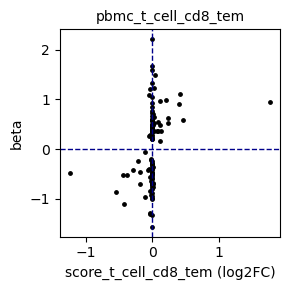

len(df_sub_pos) = 103
len(df_sub_neg) = 103
auc = 0.694
ap  = 0.737


In [9]:
#Evaluate signed effect size prediction

pip = 0.9
data_str = 'pbmc_t_cell_cd8_tem'

pred_col = 'score_t_cell_cd8_tem'
true_col = 'beta'

df_sub = df_snp_pos.query("pip >= " + str(pip)).copy().reset_index(drop=True)

auc = roc_auc_score((df_sub['beta'] >= 0.).values, df_sub[pred_col].values)
rp = pearsonr(df_sub[pred_col].values, df_sub[true_col].values)[0]
rs = spearmanr(df_sub[pred_col].values, df_sub[true_col].values)[0]

print("auc      = " + str(round(auc, 3)))
print("pearson  = " + str(round(rp, 3)))
print("spearman = " + str(round(rs, 3)))
print("n = " + str(len(df_sub)))

f = plt.figure(figsize=(3, 3))

plt.scatter(df_sub[pred_col].values, df_sub[true_col].values, color='black', s=6)

plt.axhline(y=0., linewidth=1, linestyle='--', color='darkblue')
plt.axvline(x=0., linewidth=1, linestyle='--', color='darkblue')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel(pred_col[:30] + ' (log2FC)', fontsize=10)
plt.ylabel(true_col, fontsize=10)

plt.title(data_str, fontsize=10)

plt.tight_layout()

plt.savefig('etl_' + data_str + '_pseudo_scatter.eps')

plt.show()

#Evaluate classification task (causal / non-causal)

df_sub_pos = df_snp_pos.query("pip >= " + str(pip)).copy().reset_index(drop=True)
df_sub_pos = df_sub_pos.loc[df_sub_pos['snp'].isin(df_snp_neg['matched_snp'].values.tolist())].copy().reset_index(drop=True)

df_sub_neg = df_snp_neg.loc[df_snp_neg['matched_snp'].isin(df_sub_pos['snp'].values.tolist())].copy().reset_index(drop=True)

print("len(df_sub_pos) = " + str(len(df_sub_pos)))
print("len(df_sub_neg) = " + str(len(df_sub_neg)))

df_sub_pos['is_causal'] = 1
df_sub_neg['is_causal'] = 0

df_sub = pd.concat([df_sub_pos, df_sub_neg]).copy().reset_index(drop=True)

auc = roc_auc_score(df_sub['is_causal'].values, np.abs(df_sub[pred_col].values))
ap = average_precision_score(df_sub['is_causal'].values, np.abs(df_sub[pred_col].values))

print("auc = " + str(round(auc, 3)))
print("ap  = " + str(round(ap, 3)))
